In [6]:
import torch
import alpha_clip
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2

In [7]:
mask_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((224, 224)), # change to (336,336) when using ViT-L/14@336px
    transforms.Normalize(0.5, 0.26)
])

In [8]:
# load model and prepare mask transform
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = alpha_clip.load("ViT-L/14", alpha_vision_ckpt_pth="./checkpoints/clip_l14_grit20m_fultune_2xe.pth", device=device)  # change to your own ckpt path

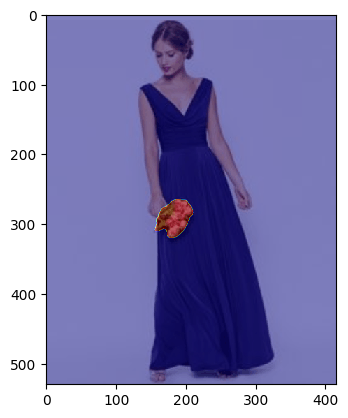

In [12]:
# prepare image and mask
img_pth = './examples/image.png'
mask_pth = './examples/flower_mask.png' # image-type mask

image = Image.open(img_pth).convert('RGB')
mask = np.array(Image.open(mask_pth)) 

fig, ax = plt.subplots()
ax.imshow(image, cmap='gray', interpolation='none')
ax.imshow(cv2.resize(mask, (np.array(image).shape[1], np.array(image).shape[0])), cmap='jet', alpha=0.5)
plt.show()


In [13]:
# get `binary_mask` array (2-dimensional bool matrix)
if len(mask.shape) == 2: binary_mask = (mask == 255)
if len(mask.shape) == 3: binary_mask = (mask[:, :, 0] == 255)

alpha = mask_transform((binary_mask * 255).astype(np.uint8))
alpha = alpha.half().cuda().unsqueeze(dim=0)

# calculate image and text features
image = preprocess(image).unsqueeze(0).half().to(device)
text = alpha_clip.tokenize(["a goegously dressed woman", "a purple sleeveness dress", "bouquet of pink flowers"]).to(device)

with torch.no_grad():
    image_features = model.visual(image, alpha)
    text_features = model.encode_text(text)

# normalize
image_features = image_features / image_features.norm(dim=-1, keepdim=True)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

## print the result
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
print("Label probs:", similarity.cpu().numpy()) # prints: [[9.388e-05 9.995e-01 2.415e-04]]

Label probs: [[3.958e-05 2.002e-02 9.800e-01]]
